In [0]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('DT Classification with Pyspark') \
    .getOrCreate()

In [0]:
df = spark.read.format('delta').\
    options(header = 'true', inferschema = 'true')\
    .load("/user/hive/warehouse/wine_data", header = 'True')

df.show(5, True)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [0]:
def condition(r):

    if (0 <= r <= 4):
        label = 'low'
    
    elif (4 < r <= 6):
        label = 'medium'

    else:
        label = 'high'
    
    return label

def string_to_float(x):
    return float(x)

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x : condition(x), StringType())

df = df.withColumn("quality", quality_udf("quality"))
df.show(5, True)
df.printSchema()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4| medium|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8| medium|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer, StringIndexer, IndexToString
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
def transData(data):
    return data.rdd.map(lambda r : [Vectors.dense(r[:-1]), r[-1]]).toDF(['features', 'label'])

transformed = transData(df)
transformed.show(5, True)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



In [0]:
from pyspark.ml.feature import VectorIndexer, StringIndexer, IndexToString
labelIndexer = StringIndexer(inputCol = 'label', outputCol = 'indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

featureIndexer = VectorIndexer(inputCol = 'features', outputCol = 'indexedFeatures', maxCategories = 4).fit(transformed)
featureIndexer.transform(transformed).show(5)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



In [0]:
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])
trainingData.show(5)
testData.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.7,0.6,0.17,2.3...|medium|
|[5.0,0.4,0.5,4.3,...|medium|
|[5.0,1.02,0.04,1....|   low|
|[5.1,0.42,0.0,1.8...|  high|
|[5.1,0.47,0.02,1....|medium|
+--------------------+------+
only showing top 5 rows

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.6,0.52,0.15,2....|   low|
|[4.9,0.42,0.0,2.1...|  high|
|[5.0,0.38,0.01,1....|medium|
|[5.0,0.42,0.24,2....|  high|
|[5.0,0.74,0.0,1.2...|medium|
+--------------------+------+
only showing top 5 rows



In [0]:
from pyspark.ml.classification import DecisionTreeClassifier

dTree = DecisionTreeClassifier(labelCol = 'indexedLabel', featuresCol = 'indexedFeatures')


In [0]:
#Pipeline Architecture

labelConverter = IndexToString(inputCol = "prediction", outputCol = 'predictedLabel', labels = labelIndexer.labels)

pipeline = Pipeline(stages = [labelIndexer, featureIndexer, dTree, labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

predictions.select('features', 'label', "predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.6,0.52,0.15,2....|   low|        medium|
|[4.9,0.42,0.0,2.1...|  high|          high|
|[5.0,0.38,0.01,1....|medium|        medium|
|[5.0,0.42,0.24,2....|  high|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [0]:
#Evaluation

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol = 'indexedLabel', predictionCol = 'prediction', metricName = 'accuracy')
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)

Test Error = 0.176568
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ffed2db639de, depth=5, numNodes=45, numClasses=3, numFeatures=11


In [0]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

Out[25]: array([[ 41,   0,  49],
       [  2,   2,  21],
       [ 24,  11, 456]])

In [0]:
#K-Means Clustering

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('K-Means Clustering with Pyspark') \
    .getOrCreate()

In [0]:
df = spark.read.format('delta').\
    options(header = 'true', inferschema = 'true')\
    .load("/user/hive/warehouse/iris", header = 'True')

df.show(5)
df.printSchema()

+------------+-------------+-------------+------------+------+
|sepal-length| sepal-length| petal-length| petal-width| Class|
+------------+-------------+-------------+------------+------+
|           1|          5.1|          3.5|         1.4|   0.2|
|           2|          4.9|          3.0|         1.4|   0.2|
|           3|          4.7|          3.2|         1.3|   0.2|
|           4|          4.6|          3.1|         1.5|   0.2|
|           5|          5.0|          3.6|         1.4|   0.2|
+------------+-------------+-------------+------------+------+
only showing top 5 rows

root
 |-- sepal-length: long (nullable = true)
 |--  sepal-length: double (nullable = true)
 |--  petal-length: double (nullable = true)
 |--  petal-width: double (nullable = true)
 |--  Class: double (nullable = true)



In [0]:
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+
|summary|      sepal-length|      sepal-length|       petal-length|       petal-width|             Class|
+-------+------------------+------------------+-------------------+------------------+------------------+
|  count|               150|               150|                150|               150|               150|
|   mean|              75.5| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|
| stddev|43.445367992456916|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|
|    min|                 1|               4.3|                2.0|               1.0|               0.1|
|    max|               150|               7.9|                4.4|               6.9|               2.5|
+-------+------------------+------------------+-------------------+------------------+------------------+



In [0]:
def transData(data):
    return data.rdd.map(lambda r : [Vectors.dense(r[:-1])]).toDF(['features'])

transformed = transData(df)
transformed.show(5, True)

+-----------------+
|         features|
+-----------------+
|[1.0,5.1,3.5,1.4]|
|[2.0,4.9,3.0,1.4]|
|[3.0,4.7,3.2,1.3]|
|[4.0,4.6,3.1,1.5]|
|[5.0,5.0,3.6,1.4]|
+-----------------+
only showing top 5 rows



In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol = "features", outputCol = 'indexedFeatures', maxCategories = 4).fit(transformed)

data = featureIndexer.transform(transformed)

data.show(5)

+-----------------+-----------------+
|         features|  indexedFeatures|
+-----------------+-----------------+
|[1.0,5.1,3.5,1.4]|[1.0,5.1,3.5,1.4]|
|[2.0,4.9,3.0,1.4]|[2.0,4.9,3.0,1.4]|
|[3.0,4.7,3.2,1.3]|[3.0,4.7,3.2,1.3]|
|[4.0,4.6,3.1,1.5]|[4.0,4.6,3.1,1.5]|
|[5.0,5.0,3.6,1.4]|[5.0,5.0,3.6,1.4]|
+-----------------+-----------------+
only showing top 5 rows



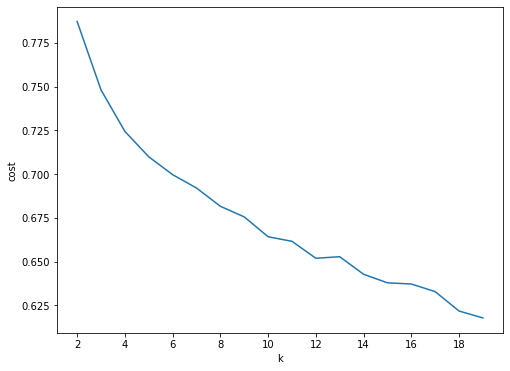

In [0]:
#Elbow Method

import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

cost = np.zeros(20)

for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("indexedFeatures").setPredictionCol("prediction")
    model = kmeans.fit(data)
    predictions = model.transform(data)
    
    evaluator = ClusteringEvaluator()
    cost[k] = evaluator.evaluate(predictions)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, 20), cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [0]:
#Pipeline Architecture

from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans().setK(3).setFeaturesCol("indexedFeatures").setPredictionCol("cluster")

pipeline = Pipeline(stages = [featureIndexer, kmeans])

model = pipeline.fit(transformed)

cluster = model.transform(transformed)

cluster.show(100)

+-------------------+-------------------+-------+
|           features|    indexedFeatures|cluster|
+-------------------+-------------------+-------+
|  [1.0,5.1,3.5,1.4]|  [1.0,5.1,3.5,1.4]|      1|
|  [2.0,4.9,3.0,1.4]|  [2.0,4.9,3.0,1.4]|      1|
|  [3.0,4.7,3.2,1.3]|  [3.0,4.7,3.2,1.3]|      1|
|  [4.0,4.6,3.1,1.5]|  [4.0,4.6,3.1,1.5]|      1|
|  [5.0,5.0,3.6,1.4]|  [5.0,5.0,3.6,1.4]|      1|
|  [6.0,5.4,3.9,1.7]|  [6.0,5.4,3.9,1.7]|      1|
|  [7.0,4.6,3.4,1.4]|  [7.0,4.6,3.4,1.4]|      1|
|  [8.0,5.0,3.4,1.5]|  [8.0,5.0,3.4,1.5]|      1|
|  [9.0,4.4,2.9,1.4]|  [9.0,4.4,2.9,1.4]|      1|
| [10.0,4.9,3.1,1.5]| [10.0,4.9,3.1,1.5]|      1|
| [11.0,5.4,3.7,1.5]| [11.0,5.4,3.7,1.5]|      1|
| [12.0,4.8,3.4,1.6]| [12.0,4.8,3.4,1.6]|      1|
| [13.0,4.8,3.0,1.4]| [13.0,4.8,3.0,1.4]|      1|
| [14.0,4.3,3.0,1.1]| [14.0,4.3,3.0,1.1]|      1|
| [15.0,5.8,4.0,1.2]| [15.0,5.8,4.0,1.2]|      1|
| [16.0,5.7,4.4,1.5]| [16.0,5.7,4.4,1.5]|      1|
| [17.0,5.4,3.9,1.3]| [17.0,5.4,3.9,1.3]|      1|
